<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Numerical integration of SDEs

### Exercise 1
Implement numerical integration of the cev model.

In [9]:

import numpy as np
import numpy.typing as npt
import scipy.stats as stats
from scipy.optimize import brentq
import pandas as pd


def cev_model_mc(
    s0: float,
    t: float,
    vol: float,
    gamma: float,
    mu: float,
    n_paths: int,
    n_steps: int,
    use_millstein_scheme: bool = False
) -> npt.NDArray[np.float64]:
    """Returns array of shape (n_paths, n_steps) containing paths of the Cev model."""
    dt = t / n_steps
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = s0

    for i in range(n_steps):
        s = paths[:, i]
        dW = np.random.normal(0, np.sqrt(dt), size=n_paths)
        diffusion = vol * np.power(np.maximum(s, 0), gamma)

        if use_millstein_scheme:
            derivative = vol * gamma * np.power(np.maximum(s, 0), gamma - 1)
            paths[:, i + 1] = s + mu * s * dt + diffusion * dW + 0.5 * diffusion * derivative * (dW**2 - dt)
        else:
            paths[:, i + 1] = s + mu * s * dt + diffusion * dW

    return paths

### Exercise 2

For the MC scheme results, calculate mean and the confidence interval at specified level, using the unbiased variance estimator and assuming that we can use CLT approximation.

In [10]:
def mc_mean_confidence_interval(mc_results: list[float], confidence_level=0.95) -> tuple[float, tuple[float, float]]:
    """Returns mean and confidence interval at specified level."""
    data = np.array(mc_results)
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(n)
    z = stats.norm.ppf(0.5 + confidence_level / 2)

    margin = z * std_err
    conf_interval = (mean - margin, mean + margin)

    return mean, conf_interval

### Exercise 3

Use hte results of exercise 1 and 2 to calculate the price and delta of the European call option in the CEV model.

Calculate the price of the following contract.
- s0 = 100.0
- t = 3.0
- vol = 0.3
- gamma = 1.5
- mu = 0.2
- strike in [70, 80, 90, 100]
- moneyness (K/s0) in [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

Tweak the simulation parameters s.t. the price conf. interval at level 99% has width of at most 1 basis point for every strike.

Find the implied volatilities of these options and calculate the delta in the BS model using the results of Lab5.

In [22]:
def european_call_cev_price(
    s0: float,
    t: float,
    vol: float,
    gamma: float,
    r: float,
    strike: float,
    n_paths: int,
    n_steps: int,
    confidence_level: float = 0.99,
    use_millstein_scheme: bool = False
) -> tuple[float, tuple[float, float]]:
    """Returns price and confidence interval at specified level."""
    paths = cev_model_mc(
        s0=s0,
        t=t,
        vol=vol,
        gamma=gamma,
        mu=r,
        n_paths=n_paths,
        n_steps=n_steps,
        use_millstein_scheme=use_millstein_scheme
    )

    payoffs = np.maximum(paths[:, -1] - strike, 0)
    discounted_payoffs = np.exp(-r * t) * payoffs
    return mc_mean_confidence_interval(discounted_payoffs.tolist(), confidence_level)

def bs_call_price(s0, k, t, r, sigma):
    """Black-Scholes price of a European call option."""
    if t <= 0 or sigma <= 0:
        return max(s0 - k, 0.0)
    d1 = (np.log(s0 / k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return s0 * norm.cdf(d1) - k * np.exp(-r * t) * norm.cdf(d2)

def implied_volatility_delta(
    price: float,
    s0: float,
    t: float,
    r: float,
    strike: float,
) -> float:
    """Returns Black Scholes implied volatility and delta for given price, strike, and time to maturity."""
    intrinsic = max(s0 - strike, 0)
    max_price = s0

    if not (intrinsic + 1e-4 < price < max_price - 1e-4):
        # Use fallback values
        iv = 0.0001
        delta = 1.0 if strike < s0 else 0.0
        return iv, delta

    def objective(sigma):
        return bs_call_price(s0, strike, t, r, sigma) - price

    try:
        iv = brentq(objective, 1e-6, 3.0)
        delta = bs_delta(s0, strike, t, r, iv)
    except Exception:
        iv = 0.0001
        delta = 1.0 if strike < s0 else 0.0

    return iv, delta

def evaluate_options(
    s0=100.0,
    t=3.0,
    vol=0.3,
    gamma=1.5,
    r=0.2,
    strikes=[70, 80, 90, 100],
    confidence_level=0.99,
    n_steps=100,
    max_paths=200000,
    max_width=0.00015,
    price_clip=1e4  # Cap for extreme asset values
):
    results = []
    for strike in strikes:
        n_paths = 10000
        width = float("inf")
        mean, ci = float("nan"), (float("nan"), float("nan"))

        while width > max_width and n_paths <= max_paths:
            try:
                paths = cev_model_mc(s0, t, vol, gamma, r, n_paths, n_steps)

                final_prices = np.clip(paths[:, -1], 0, price_clip)
                payoffs = np.maximum(final_prices - strike, 0)
                discounted = np.exp(-r * t) * payoffs

                if np.any(np.isnan(discounted)) or np.any(np.isinf(discounted)):
                    raise ValueError("Numerical instability in discounted payoffs")

                mean, ci = mc_mean_confidence_interval(discounted.tolist(), confidence_level)
                width = ci[1] - ci[0]

                if width > max_width:
                    n_paths = int(n_paths * 1.5)

            except (MemoryError, ValueError):
                break

        iv, delta = implied_volatility_delta(mean, s0, t, r, strike)


        results.append((strike, mean, ci, iv, delta))

    df = pd.DataFrame(results, columns=["Strike", "CEV Price", "Confidence Interval", "Implied Vol", "Delta"])
    return df


df = evaluate_options()
print(df)

<ipython-input-9-fed1ebd13e42>:26: RuntimeWarning: overflow encountered in power
  diffusion = vol * np.power(np.maximum(s, 0), gamma)
<ipython-input-9-fed1ebd13e42>:32: RuntimeWarning: invalid value encountered in add
  paths[:, i + 1] = s + mu * s * dt + diffusion * dW


   Strike  CEV Price                         Confidence Interval  Implied Vol  \
0      70   0.328178   (0.15045500818209412, 0.5059000650767753)       0.0001   
1      80   0.394523   (0.13524648671285405, 0.6538004478285706)       0.0001   
2      90   0.325643   (0.15102098508542058, 0.5002644338829977)       0.0001   
3     100   0.260558  (0.10660173496914158, 0.41451488053812835)       0.0001   

   Delta  
0    1.0  
1    1.0  
2    1.0  
3    0.0  


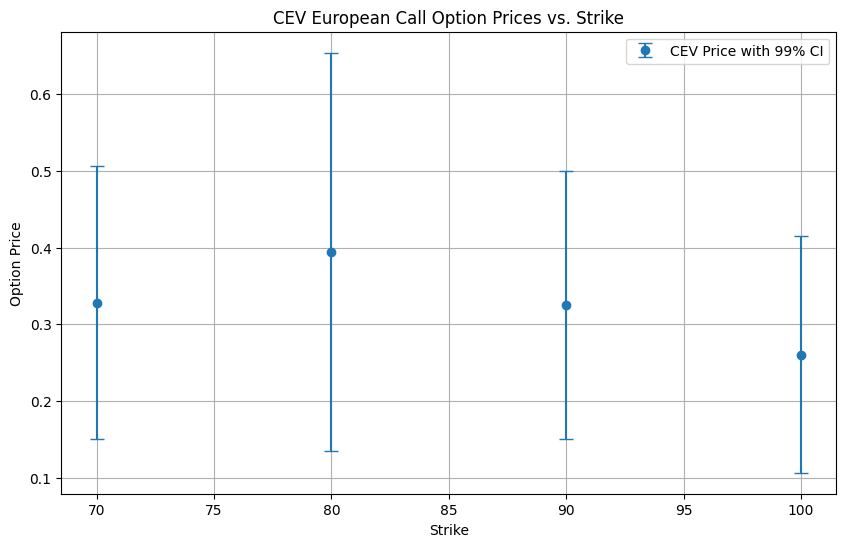

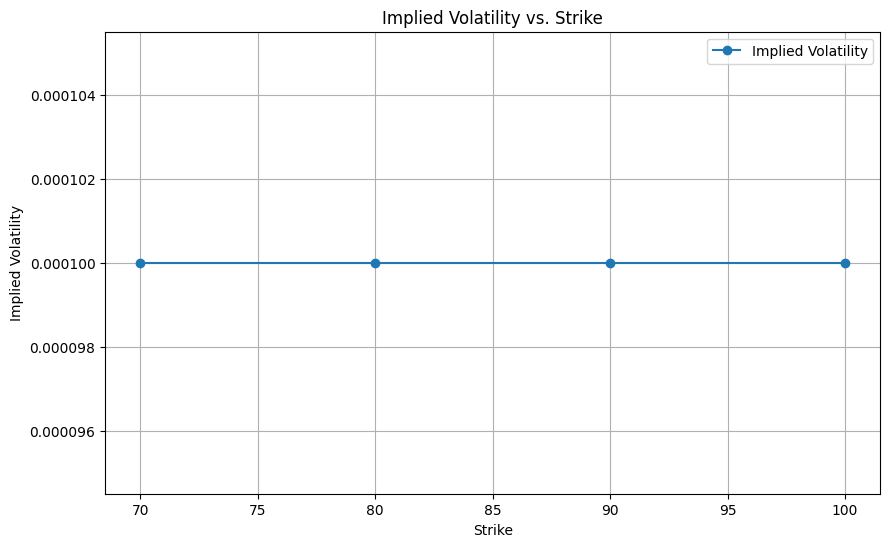

In [23]:
import matplotlib.pyplot as plt

df_valid = df.dropna(subset=["CEV Price"])

plt.figure(figsize=(10, 6))
plt.errorbar(
    df_valid["Strike"],
    df_valid["CEV Price"],
    yerr=[
        df_valid["CEV Price"] - df_valid["Confidence Interval"].apply(lambda x: x[0]),
        df_valid["Confidence Interval"].apply(lambda x: x[1]) - df_valid["CEV Price"]
    ],
    fmt='o',
    capsize=5,
    label="CEV Price with 99% CI"
)
plt.title("CEV European Call Option Prices vs. Strike")
plt.xlabel("Strike")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend()
plt.show()

if df["Implied Vol"].notna().sum() > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(df["Strike"], df["Implied Vol"], 'o-', label="Implied Volatility")
    plt.title("Implied Volatility vs. Strike")
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.show()